# Speech Emotion Recognition


#### Task Description：
Fine-tune Hubert model for Speech Emotion Recognition.


#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 

## 1. General Preparation

Import some common libraries.

In [1]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2024-07-01 09:05:25.114118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 09:05:25.114256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 09:05:25.229493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Use GPU Facilities.

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla T4


In [3]:
indian_df = pd.read_csv('/kaggle/input/dataframes/crema_df.csv')

In this demonstration, I am only choosing 4 emotions, neutral, happy, sad and angry.

In [4]:
indian_df = indian_df[(indian_df["Emotions"]=="neutral") | (indian_df["Emotions"]=="happy") | (indian_df["Emotions"]=="sad") | (indian_df["Emotions"]=="angry")]

Split into training data and test data.

In [5]:
train_df = indian_df.sample(frac=0.8)
test_df = indian_df.drop(train_df.index)

Let's have a look at the training data.

### 2.2 Tokenization

In [6]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/3920 [00:00<?, ? examples/s]

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [7]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happy': 1,
            'sad': 2,
            'angry': 3,
            'fear': 4,
            'disgust': 5
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["Emotions"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["Emotions"]))


## 3. Loading the Model and Optimizer 

In [8]:
#import torch.nn as nn
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
#model.classifier = nn.Linear(model.classifier.in_features, 6)
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

## 4. Training

Prepare some utility functions.

In [9]:
# Check unique labels in the training and test data
print(set(train_data["Emotions"]))
print(set(test_data["Emotions"]))

{'angry', 'neutral', 'sad', 'happy'}
{'angry', 'neutral', 'sad', 'happy'}


In [10]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [11]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 10

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 1960/1960 [14:46<00:00,  2.21it/s, Loss=0.308, Accuracy=0.596]


Epoch 2/10


100%|██████████| 1960/1960 [14:55<00:00,  2.19it/s, Loss=0.253, Accuracy=0.729]


Epoch 3/10


100%|██████████| 1960/1960 [14:55<00:00,  2.19it/s, Loss=0.460, Accuracy=0.772]


Epoch 4/10


100%|██████████| 1960/1960 [14:54<00:00,  2.19it/s, Loss=0.255, Accuracy=0.812]


Epoch 5/10


100%|██████████| 1960/1960 [14:55<00:00,  2.19it/s, Loss=0.313, Accuracy=0.829]


Epoch 6/10


100%|██████████| 1960/1960 [14:53<00:00,  2.19it/s, Loss=0.228, Accuracy=0.847]


Epoch 7/10


100%|██████████| 1960/1960 [14:54<00:00,  2.19it/s, Loss=0.323, Accuracy=0.865]


Epoch 8/10


 44%|████▍     | 869/1960 [06:38<08:08,  2.23it/s, Loss=0.001, Accuracy=0.872]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1960/1960 [14:58<00:00,  2.18it/s, Loss=0.215, Accuracy=0.878]


Epoch 9/10


100%|██████████| 1960/1960 [14:57<00:00,  2.18it/s, Loss=0.005, Accuracy=0.888]


Epoch 10/10


100%|██████████| 1960/1960 [14:54<00:00,  2.19it/s, Loss=0.011, Accuracy=0.904]


In [16]:
torch.save(model.state_dict(), '/kaggle/working/model_final_epoch.pth')

In [17]:
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([1, 69937])
attention_mask shape: torch.Size([1, 69937])
labels shape: torch.Size([1])


Visualise the training loss and accuracy.

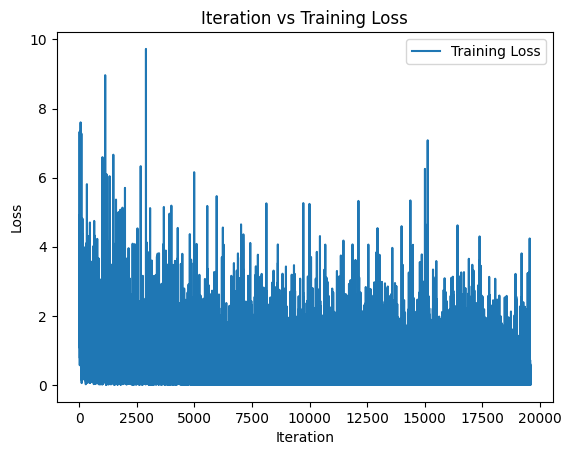

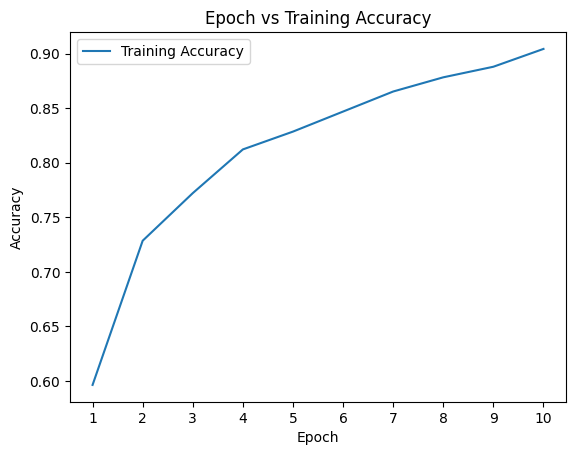

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [19]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 980/980 [01:08<00:00, 14.33it/s, loss=0.031, accuracy=0.879]


The final accuracy on the test dataset: 87.8571%


Check the result.

In [20]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["Emotions"] = df.apply(lambda x: x["Emotions"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["Emotions"]!=df["Model Prediction"]]

,index,Emotions,Path,Model Prediction
1,42,ang,/kaggle/input/cremad/AudioWAV/1073_IOM_ANG_XX.wav,sad
4,70,ang,/kaggle/input/cremad/AudioWAV/1041_IEO_ANG_LO.wav,sad
9,121,sad,/kaggle/input/cremad/AudioWAV/1029_TAI_SAD_XX.wav,ang
10,130,ang,/kaggle/input/cremad/AudioWAV/1028_IWL_ANG_XX.wav,sad
12,154,sad,/kaggle/input/cremad/AudioWAV/1001_WSI_SAD_XX.wav,hap
...,...,...,...,...
973,7414,ang,/kaggle/input/cremad/AudioWAV/1020_IWW_ANG_XX.wav,sad
976,7432,ang,/kaggle/input/cremad/AudioWAV/1011_TIE_ANG_XX.wav,sad
977,7434,ang,/kaggle/input/cremad/AudioWAV/1033_WSI_ANG_XX.wav,sad
978,7436,ang,/kaggle/input/cremad/AudioWAV/1008_IEO_ANG_MD.wav,sad


Display the Confusion Matrix of the result.

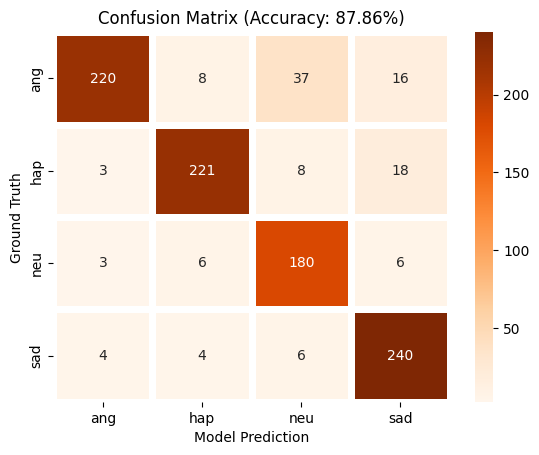

In [21]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()